In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt):
    params = plt.gcf()
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*N, plSize[1]*N) )
def increase_figsize2(N, fig):
    params = fig
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*N, plSize[1]*N) )
def increase_size_by(N, fontsize, plt):
    params = plt.gcf()
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*N, plSize[1]*N) )
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
all_genome_classification = pd.read_csv('/home/hielke/bep/data/reclassify_combine/re_systems_comb.6.m', sep='\t', dtype={'genome': str})

In [4]:
dfo = pd.read_csv('fp_combined_with_extra.tsv', sep='\t', dtype={'genome': str, 'prophage': float,
                })
print(len(dfo['genome'].unique()))
# OPTIONAL TO INCREASE LOWER BOUNDARY FOR IDENTITY
df = dfo.query("ident == 100")
# df = dfo.copy()

41347


In [5]:
dfe = pd.read_csv('/home/hielke/bep/data/reclassify_combine/all_meta_info_super_enhanced', sep='\t', names=['genome', 'custom_old_array', 'contig', 'old_repeat', 'array', 'a_1', 'a_2', 'new_repeat', 'custom_new_array', 'conf', 'add_inf', 'type'], dtype={'genome': str}, index_col='array')

In [6]:
affected_arrays = set(df.index)

In [7]:
all_genomes = pd.read_csv("/home/hielke/bep/data/filterdata/all_genomes_listed", header=None)
all_genomes['genome'] = all_genomes[0].apply(lambda x: ".".join(x.split(".")[:-1]))
del all_genomes[0]
all_genomes.set_index('genome', inplace=True)
all_genomes.head()

""
genome
100053.4
100053.5
100053.6
100053.7
100053.8


In [78]:
# combinations = dfr.groupby(['genome_x', 'cat']).groups.keys()
# from collections import defaultdict
# found_genomes = defaultdict(set)
# for genome, cat in combinations:
#     found_genomes[genome].add(cat)
# mixed_systems = set([genome for genome, val in found_genomes.items() if len(val) > 1])
# which_systems_mixed = [(val, genome, int(dfa.query("genome == @genome")['selfhit_count_sum'])) for genome, val in found_genomes.items() if len(val) > 1]
# print(len(mixed_systems))
# print(len(set(dfr['genome_x'])))
# dfrr = dfr[~dfr['genome_x'].isin(mixed_systems)]

In [8]:
import re

def multiple_type_interpretation(atype):
    if len(atype) != 1:
        main_type = set([t.split("-")[0] for t in atype])
        if len(main_type) == 1:
            if len(atype) == 2:
                res = main_type.pop() + "-"
                subtypes = sorted([t.split("-")[1] for t in atype])
                return res + "/".join(subtypes)
            return main_type.pop()
        elif len(main_type) == 0:
            return "Only Cas1 or Cas2"
        else:
            return "Multiple System"
    res = atype.pop()
    if not res:
        return "Only Cas1 or Cas2"
    return res

def get_cat(x):
    if pd.isnull(x['add_inf']):
        return "Not associated"
    if pd.isnull(x['type']):
        return "Only Cas1 or Cas2"
    atype = set(t for t in re.split(r'&|,', x['type']) if t)
    return multiple_type_interpretation(atype)
    
dfe['cat'] = dfe.apply(get_cat, axis=1)



In [9]:
from operator import itemgetter
from itertools import chain

def return_the_best(candidates, key, return_top=False):
    top = max(map(key, candidates))
    res = [t for t in candidates if key(t) == top]
    if return_top:
        return res, top
    return res

def get_completeness(x):
    completeness_dict = {"Complete": 1, "Single": 0, "Partial": -1, "nan": -2}
    val = "nan" if pd.isnull(x[1]) else x[1].split(",")[2]
    
    return completeness_dict[val]

def classify_without_repeat(max_conf_gathered, max_conf=None):
    max_completeness_gathered = return_the_best(max_conf_gathered, 
                                                key=get_completeness)
    if len(max_completeness_gathered) == 1:
        return max_completeness_gathered[0]
    max_adaption_gathered = return_the_best(max_completeness_gathered, key=lambda x: int(x[1].split(",")[0]))
    if len(max_adaption_gathered) == 1:
        return max_adaption_gathered[0]
    types = set(map(lambda x: x[0].split("-")[0], max_adaption_gathered))
    if max_conf == 3.0 and len(types) == 1:
        return_type_main = max_adaption_gathered[0][0].split("-")[0] + "-"
        return_type_main += "/".join(sorted(set(chain(*map(lambda x: x[0].split("-")[1].split("/"), max_adaption_gathered)))))
        return [return_type_main, max_adaption_gathered[0][1], max_adaption_gathered[0][2]]
    if len(types) == 1:
        return [types.pop(), max_adaption_gathered[0][1], max_adaption_gathered[0][2]]
    return ["Multiple System", max_adaption_gathered[0][1], max_adaption_gathered[0][2]]

def reform_ding(ding):
    
    cats = set()
    cats_inf = list()
    for VU, adap, ambi, complete, subtype in zip(ding['VU'].values, ding['adaption_module'].values, ding['ambiguous'].values,
                                  ding['completeness'].values, ding['subtype'].values):
        if subtype in cats or VU in cats:
            continue
        if pd.isnull(subtype):
            if not pd.isnull(VU):
                subtype = VU
            else: 
                continue
        subtype = multiple_type_interpretation(set(subtype.split(",")))
        cats.add(subtype)
        cats_inf.append([subtype, "%d,%d,%s" % (adap, ambi, complete), np.nan])
    if len(cats_inf) == 0:
        cats_inf = [["Only Cas1 or Cas2", np.nan, np.nan]]
    return classify_without_repeat(cats_inf, None)

genome_typing_no_repeat = all_genome_classification.groupby('genome').apply(lambda x: pd.Series({key: val for key, val in zip(['typing', 'more_inf', 'more_conf'], reform_ding(x))}))

In [10]:
from operator import itemgetter
from itertools import chain

selfhit_spacers_not_associated_genomes = set()

def get_single_cat(ding):
    temp_ding = ding[ding.index.isin(affected_arrays)]
    if len(temp_ding) != 0:
        ding = temp_ding
    # collect the ones
    cats = set()
    cats_inf = list()
    for cat, add_inf, conf in zip(ding['cat'].values, ding['add_inf'].values, ding['conf'].values):
        if cat == "Not associated" or cat in cats:
            continue
        cats.add(cat)
        add_inf = add_inf.split("&")[0]
        cats_inf.append([cat, add_inf, conf])
    
    if len(cats_inf) == 0:
        # apply fallback
        genome = ding['genome'].values[0]
        selfhit_spacers_not_associated_genomes.add(genome)
        try:
            return list(genome_typing_no_repeat.loc[genome])
        except KeyError:
            return ["No CRISPR genes", np.nan, np.nan]
    if len(cats_inf) == 1:
        return cats_inf[0]
    remove_cas1_2 = [t for t in cats_inf if t[0] != "Only Cas1 or Cas2"]
    if len(remove_cas1_2) == 0:
        return cats_inf[0]
    remove_multiple = [t for t in remove_cas1_2 if t[0] != "Multiple System"]
    if len(remove_multiple) == 0:
        return remove_cas1_2[0]
    if len(remove_multiple) == 1:
        return remove_multiple[0]
    remove_main = [t for t in remove_multiple if '-' in t[0]]
    if len(remove_main) == 0:
        return ["Multiple System", remove_multiple[0][1], remove_multiple[0][2]]
    if len(remove_main) == 1:
        return remove_main[0]
    max_conf_gathered, max_conf = return_the_best(remove_main, key=itemgetter(2), return_top=True)
    if len(max_conf_gathered) == 1:
        return max_conf_gathered[0]
    return classify_without_repeat(max_conf_gathered, max_conf)

genome_typing = dfe.groupby('genome').apply(lambda x: pd.Series({key: val for key, val in zip(['typing', 'more_inf', 'more_conf'], get_single_cat(x))}))


In [11]:
genome_typing_complete = all_genomes.merge(genome_typing, left_index=True, right_index=True, how='left')

In [12]:
genome_typing_complete = genome_typing_complete.combine_first(genome_typing_no_repeat)

In [13]:
genome_typing_complete.typing.fillna("No CRISPR genes", inplace=True)

In [14]:
genome_typing_complete.typing.value_counts()

TypeI-E              10652
No CRISPR genes       8460
TypeIII-A             7186
TypeI-F               2851
TypeII-A              2053
TypeI-B               1920
TypeI-C               1623
TypeV-U4              1381
TypeII                1170
Multiple System       1076
Only Cas1 or Cas2      701
TypeI                  389
TypeII-C               227
TypeI-D                187
TypeIII-B              181
TypeI-U                176
TypeII-B               146
TypeI-A                143
TypeIII-D              139
TypeIII-C              138
TypeVI-B               107
TypeV-A                 71
TypeIV                  62
TypeV-B                 40
TypeV-U3                37
TypeII-A/C              34
TypeV-E                 28
TypeI-E/F               24
TypeIII                 23
TypeI-C/U               21
TypeV-U1                13
TypeV-D                 11
TypeV-C                  9
TypeI-C/F                9
TypeV-U5                 9
TypeVI-A                 8
TypeVI-C                 7
T

In [15]:
genome_typing_complete.head()

,typing,more_inf,more_conf
genome,,,
100053.4,TypeI-E,"1,0,Partial",NaN
100053.5,TypeI-E,"1,1,Partial",1.0
100053.6,TypeI-E,"0,0,Partial",NaN
100053.7,TypeI-E,"1,1,Partial",1.0
100053.8,TypeI-E,"1,0,Partial",1.0


In [16]:
df.index = df['spacer'].map(lambda x: "_".join(x.split("_")[:-1]))
dfc = df.merge(dfe, left_index=True, right_index=True, how='left')

In [17]:
df.index = df['genome']
dfcc = df.merge(genome_typing_complete, left_index=True, right_index=True, how='left')

In [18]:
dfcc.head()

,genome,Genes present,Number of CRISPRs,System type,Total Cas Prots,Total non V-U Prots,c_1,c_2,cas1 missing,contig_hit,genus,has_phages,ident,length,missing RSAs,missing signature prot,multiple systems,prophage,spacer,species,system subtype,total_spacers,typing,more_inf,more_conf
genome,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,496.0,464.0,0,JQGS01000250,Leptospira,-1.0,100.0,33.0,not all loci have repeats,0,2.0,-1.0,JQGS01000134_1_1,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,25061.0,25029.0,0,JQGS01000037,Leptospira,-1.0,100.0,33.0,not all loci have repeats,0,2.0,-1.0,JQGS01000134_1_3,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,13121.0,13089.0,0,JQGS01000037,Leptospira,-1.0,100.0,33.0,not all loci have repeats,0,2.0,-1.0,JQGS01000134_1_4,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,24550.0,24519.0,0,JQGS01000037,Leptospira,-1.0,100.0,32.0,not all loci have repeats,0,2.0,-1.0,JQGS01000065_1_1,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,5128.0,5159.0,0,JQGS01000037,Leptospira,-1.0,100.0,32.0,not all loci have repeats,0,2.0,-1.0,JQGS01000065_1_7,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN


In [19]:
def print_classification_by_type(ding):
    with open("classifications2/" + "_".join(ding['typing'].values[0].split()).replace("/", "|"), 'w') as f:
        for genome in ding.index:
            print(genome, file=f)
genome_typing_complete.groupby('typing').apply(print_classification_by_type)

""


In [ ]:
combinations = dfc.groupby(['genome_x', 'cat']).groups.keys()
from collections import defaultdict
found_genomes = defaultdict(set)
for genome, cat in combinations:
    found_genomes[genome].add(cat)
for genome, val in found_genomes.items():
    if len(val) > 1:
        pass
# this breaks since it needs a merge which is now delayed. 
dfc['cat'].value_counts().plot.barh(color="darkseagreen")
increase_figsize(2, plt)
sns.despine()
plt.gca().set_xscale('log')
plt.title("CRISPR System association")

In [15]:
# dfrr['partial'] = dfrr['add_inf'].map(lambda x: "Partial" in x.split(","))
# partial_systems = dfrr.groupby('genome_x')['partial'].nth(0)
# partial_systems = set(partial_systems[partial_systems].index)
# print(len(partial_systems))

740


/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


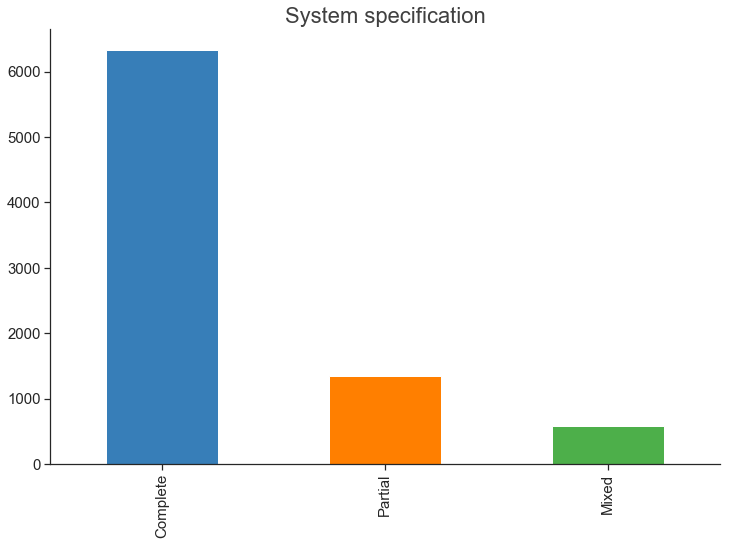

In [16]:
# def system_specifcation(genome):
#     return "Mixed" if genome in mixed_systems else "Partial" if genome in partial_systems else "Complete"
# dfr['System specification'] = dfr["genome_x"].apply(system_specifcation)
# fig = dfr["System specification"].value_counts().plot.bar()
# sns.despine()
# plt.title("System specification")
# increase_figsize(2, plt)
# plt.savefig("/home/hielke/bep/jups/new_figs/system_specification.png", format='png', bbox_inches='tight')
# group_order=["Complete", "Partial", "Mixed"]

In [60]:
# dfrr["System specification"] = dfrr['genome_x'].apply(system_specifcation)
# dfs = dfr.copy()
# dfs.rename(columns={"system subtype": "discotype", "genome_x": "genome"}, inplace=True)
# dfs.rename(columns={"type": "system subtype"}, inplace=True)

/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
from scipy.special import comb
from functools import lru_cache

def orientation_chance(spacers, value_counts):
    # Bonferonni
    p_val = .05 / value_counts[spacers]
    combi_chance = .5 ** spacers
    total_chance = 0
    wrong = 0
    while total_chance < p_val:
        wrong += 1
        total_chance += comb(spacers, wrong) * combi_chance
    allowed_wrong = wrong - 1
    if allowed_wrong == 0: 
        if combi_chance < p_val:
            return 0.0
        return -1.0
    return allowed_wrong / spacers


orientation = dfcc.groupby(['contig_hit', 'genome'], ).apply((lambda x: np.sum(0 < x['c_1'] - x['c_2']) / len(x) if len(x) > 4 else -1.0), )
# orientation['sum'] = dfcc.groupby(['contig_hit', 'genome']).agg('count')
orientation = orientation.to_frame()
orientation = orientation.merge(dfcc.groupby(['contig_hit', 'genome'])['c_1'].agg('count').to_frame(), left_index=True, right_index=True)
orientation = orientation.rename({0: "orientation", "c_1": "sum"}, axis='columns')
orientation_bias = orientation[( (orientation.orientation != -1.0) )]
# orientation_bias.head(50)
# ding = orientation_bias.iloc[3]
# print(ding)
# print((lambda row: (row.orientation <= orientation_chance(row['sum'])) or 
#                                  (row.orientation >= 1 - orientation_chance(row['sum'])))(ding))
booleans_ori = orientation_bias.apply(lambda row: 
                                      (row.orientation <= orientation_chance(row['sum'], orientation_bias['sum'].value_counts())) or 
                                (row.orientation >= 1 - orientation_chance(row['sum'], orientation_bias['sum'].value_counts())), axis=1)
# print(len(booleans_ori))
# print(sum(booleans_ori))
orientation_bias_genomes = set(orientation_bias[booleans_ori].reset_index()['genome'])
dfcc['orientation_bias'] = dfcc['genome'].isin(orientation_bias_genomes)
orientation_bias[booleans_ori]

/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


,,orientation,sum
contig_hit,genome,,
AMRI01000064,745411.4,0.000000,36
ARET01000029,1121114.4,0.157895,19
AVIK01000001,1151306.3,1.000000,12
AVIK01000005,1151306.3,0.000000,12
AWSB01000004,1227261.3,0.000000,11
CARW01000044,1265628.3,1.000000,10
CM001981,1224148.3,1.000000,11
CP006956,1263832.3,0.238095,21
CZWV01000144,1496.900,1.000000,24


In [31]:
# dfs: selfhits grouped by spacer (with a boundary of 100 percent identity)
dfs = dfcc.copy()
dfs['selfhit_count'] = dfs.groupby('spacer')['spacer'].transform('count')
dfs['selfhit_count'].fillna(0, inplace=True)
dfs.drop(columns=['ident'], inplace=True)
dfs['unknown_prophage'] = dfs.groupby('genome')['prophage'].transform(lambda s: np.sum(s.values == -1.0))
dfs['no_prophage'] = dfs.groupby('genome')['prophage'].transform(lambda s: np.sum(s.values == 0.0))
dfs['from_prophage'] = dfs.groupby('genome')['prophage'].transform(lambda s: np.sum(s.values > 0.0))
dfs.drop_duplicates(subset=['spacer', 'genome'], inplace=True)
# dfs.head()

# dfa: selfhits grouped by the genomes. (sum/mean/median)
dfa = dfs.copy()
dfa['selfhit_count_sum'] = dfa.groupby('genome')['selfhit_count'].transform('sum')
dfa['selfhit_count_mean'] = dfa.groupby('genome')['selfhit_count'].transform('mean')
dfa['selfhit_count_median'] = dfa.groupby('genome')['selfhit_count'].transform('median')
dfa['selfhit_spacers'] = dfa.groupby('genome')['selfhit_count'].transform('count')

# prophage category summed

dfa.drop(columns=['length', 'spacer', 'selfhit_count'], inplace=True)
dfa.drop_duplicates('genome', keep='first', inplace=True)

# dfa['group'] = dfa.apply(define_cat, axis=1)
# dfa['system subtype'] = dfa.apply(lambda row: 'TypeIV' 
#                                   if row['system subtype'] == '0' and row['group'] == "Single System" 
#                                   else row['system subtype'],
#                                  axis=1)

dfa['percentage_selfhits'] = dfa['selfhit_spacers'] / dfa['total_spacers'] * 100

dfa.head()
print(len(dfa))

/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  import sys
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


8272


/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambi

In [22]:
dfa.head()

,genome,Genes present,Number of CRISPRs,System type,Total Cas Prots,Total non V-U Prots,c_1,c_2,cas1 missing,contig_hit,genus,has_phages,missing RSAs,missing signature prot,multiple systems,prophage,species,system subtype,total_spacers,typing,more_inf,more_conf,unknown_prophage,no_prophage,from_prophage,selfhit_count_sum,selfhit_count_mean,selfhit_count_median,selfhit_spacers,percentage_selfhits
genome,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,496.0,464.0,0,JQGS01000250,Leptospira,-1.0,not all loci have repeats,0,2.0,-1.0,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN,17.0,0.0,0.0,17,1.0,1.0,17,42.500000
100053.5,100053.5,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,1273.0,1242.0,0,JQGU01000091,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56643,TypeI-E,40.0,TypeI-E,"1,1,Partial",1.0,2.0,0.0,0.0,2,1.0,1.0,2,5.000000
100053.6,100053.6,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,11256.0,11287.0,0,JQGV01000052,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56640,TypeI-E,81.0,TypeI-E,"0,0,Partial",NaN,2.0,0.0,0.0,2,1.0,1.0,2,2.469136
100053.7,100053.7,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,927.0,958.0,0,JQGT01000194,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56159,TypeI-E,45.0,TypeI-E,"1,1,Partial",1.0,13.0,0.0,0.0,13,1.0,1.0,13,28.888889
100053.8,100053.8,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,12307.0,12339.0,0,JQGW01000084,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56659,TypeI-E,22.0,TypeI-E,"1,0,Partial",1.0,4.0,0.0,0.0,4,1.0,1.0,4,18.181818


/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: 'genome' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


,,orientation,sum
contig_hit,genome,,
ARET01000029,1121114.4,0.157895,19
AWSB01000004,1227261.3,0.000000,11
AYKY01000075,1239287.3,1.000000,9
CM001981,1224148.3,1.000000,11
CP011913,1408268.58,0.909091,11
CZWV01000144,1496.900,1.000000,12
CZWV01000161,1496.900,0.000000,12
JKDE01000013,1423543.3,1.000000,10
JNMV01000109,1444058.3,0.000000,10


In [24]:
# dfdg = pd.read_csv('/home/hielke/bep/data/disco/discodata/MasterMaster', 
#                   dtype={'Total non V-U Prots': int, 'Total Cas Prots': int}, index_col=0)
# dfdg['group'] = dfdg.apply(define_cat, axis=1)
# dfdg['system subtype'] = dfdg.apply(lambda row: 'TypeIV' 
#                                   if row['system subtype'] == '0' and row['group'] == "Single System" 
#                                   else row['system subtype'],
#                                  axis=1)
# value_counts_all = dfdg.query('group == "Single System"')["system subtype"].value_counts()
# value_counts_all

In [128]:
single_df = dfa.copy()
value_counts_unbound = single_df["typing"].value_counts()
crisprlisted_unbound = list(value_counts_unbound.index)
minimum_spacers = 1
single_df_bounded = single_df.copy(deep='all')
single_df_bounded.query('selfhit_spacers > @minimum_spacers', inplace=True)
value_counts_bounded = single_df_bounded["typing"].value_counts()
def limit(single_df_bounded, value_counts_bounded, bound):
    to_keep = value_counts_bounded[value_counts_bounded >= bound]
    to_remove = value_counts_bounded[value_counts_bounded < bound]
    if len(to_remove) < 2:
        print("Nothing to remove")
        print(list(to_keep.index))
        print(len(list(to_keep.index)))
        return single_df_bounded, list(to_keep.index)
    single_df_bounded['typing'].replace(to_remove.index, "Other", inplace=True)
    crisprlisted_bounded = list(to_keep.index)
    crisprlisted_bounded.append("Other")
    print(crisprlisted_bounded)
    print(len(crisprlisted_bounded))
    print(to_remove)
    print(to_keep)
    return single_df_bounded, crisprlisted_bounded
print("BOUNDED ==========")
single_df_bounded, crisprlisted_bounded = limit(single_df_bounded, value_counts_bounded, 5)
single_df_limited = single_df.copy()
print("LIMITED ==========")
single_df_limited, crisprlisted_limited = limit(single_df_limited, value_counts_unbound, 30)
single_df_phages = single_df[single_df['has_phages'] != -1.0]
single_df_phages['percentage_phagehit'] = single_df_phages['from_prophage'].div(single_df_phages['selfhit_count_sum']).mul(100)
value_counts_phages = single_df_phages['typing'].value_counts()
single_df_phages, crisprlisted_phages = limit(single_df_phages, value_counts_phages, 6)

BOUNDED ==========
['No CRISPR genes', 'TypeI-F', 'TypeI-E', 'TypeI-B', 'TypeIII-A', 'TypeII-A', 'TypeI-C', 'TypeII-C', 'TypeII', 'Only Cas1 or Cas2', 'TypeV-U4', 'Multiple System', 'TypeI-D', 'TypeI', 'TypeI-E/F', 'TypeI-U', 'TypeII-B', 'TypeIII-B', 'TypeV-A', 'TypeVI-B', 'TypeII-A/C', 'TypeIII-C', 'TypeIII-D', 'TypeI-C/F', 'TypeV-E', 'TypeV-B', 'Other']
27
TypeIV         4
TypeI-C/E      3
TypeI-C/E/F    2
TypeV-C        2
TypeI-A        2
TypeVI-C       1
TypeIII        1
TypeI-A/C      1
TypeV-D        1
TypeI-A/B      1
TypeV-U1       1
TypeV-U3       1
TypeVI-A       1
TypeV-U5       1
Name: typing, dtype: int64
No CRISPR genes      668
TypeI-F              605
TypeI-E              538
TypeI-B              361
TypeIII-A            271
TypeII-A             237
TypeI-C              204
TypeII-C              93
TypeII                67
Only Cas1 or Cas2     61
TypeV-U4              56
Multiple System       43
TypeI-D               21
TypeI                 19
TypeI-E/F             18

/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [29]:
single_df_limited.head()

,genome,Genes present,Number of CRISPRs,System type,Total Cas Prots,Total non V-U Prots,c_1,c_2,cas1 missing,contig_hit,genus,has_phages,missing RSAs,missing signature prot,multiple systems,prophage,species,system subtype,total_spacers,typing,more_inf,more_conf,unknown_prophage,no_prophage,from_prophage,selfhit_count_sum,selfhit_count_mean,selfhit_count_median,selfhit_spacers,percentage_selfhits
genome,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,100053.4,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI|TypeIV,12.0,12.0,496.0,464.0,0,JQGS01000250,Leptospira,-1.0,not all loci have repeats,0,2.0,-1.0,Leptospira alexanderi strain 56650,TypeI-E,40.0,TypeI-E,"1,0,Partial",NaN,17.0,0.0,0.0,17,1.0,1.0,17,42.500000
100053.5,100053.5,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,1273.0,1242.0,0,JQGU01000091,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56643,TypeI-E,40.0,TypeI-E,"1,1,Partial",1.0,2.0,0.0,0.0,2,1.0,1.0,2,5.000000
100053.6,100053.6,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,11256.0,11287.0,0,JQGV01000052,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56640,TypeI-E,81.0,TypeI-E,"0,0,Partial",NaN,2.0,0.0,0.0,2,1.0,1.0,2,2.469136
100053.7,100053.7,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,927.0,958.0,0,JQGT01000194,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56159,TypeI-E,45.0,TypeI-E,"1,1,Partial",1.0,13.0,0.0,0.0,13,1.0,1.0,13,28.888889
100053.8,100053.8,Ref_set_from_Makarova_2015_cse2gr11_generated_...,1.0,TypeI,8.0,8.0,12307.0,12339.0,0,JQGW01000084,Leptospira,-1.0,NaN,0,1.0,-1.0,Leptospira alexanderi strain 56659,TypeI-E,22.0,TypeI-E,"1,0,Partial",1.0,4.0,0.0,0.0,4,1.0,1.0,4,18.181818


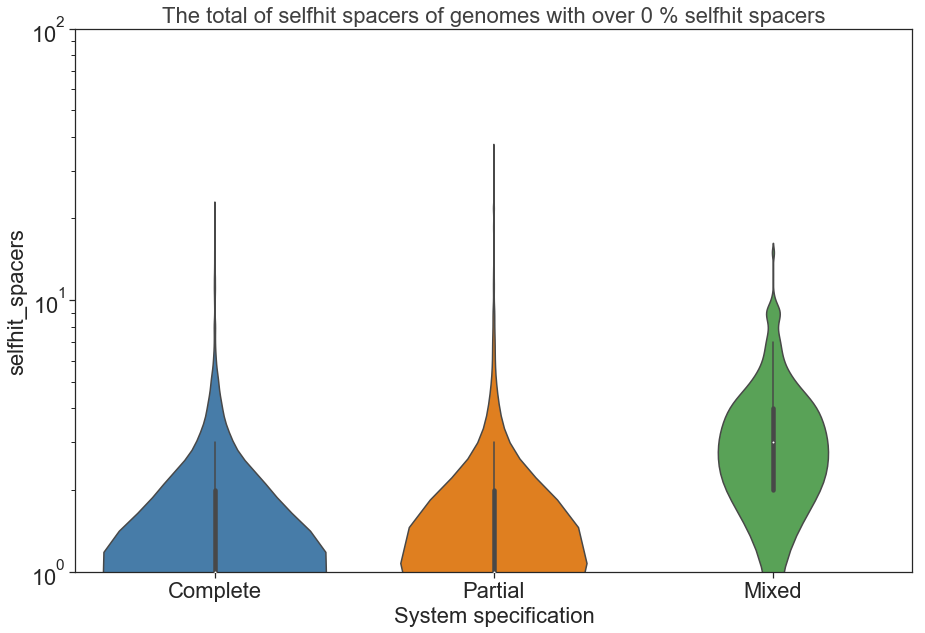

In [47]:
# Set dfs to dfr instead (dfrr is mixed system free)
boundary = 0
group_order=["Complete", "Partial", "Mixed"]
fig, ax = plt.subplots()
sns.violinplot(y='selfhit_spacers', x='System specification', 
              data=dfa.query('percentage_selfhits > @boundary'), order=group_order, ax=ax, bw=.3)
plt.title("The total of selfhit spacers of genomes with over %d %% selfhit spacers" % int(boundary))
# dfa.query('percentage_selfhits == 1').head()
# print("Total of %d genomes" % len(dfa.query('percentage_selfhits > @boundary')))
# print("No System: %d" % len(dfa.query('percentage_selfhits > @boundary & group=="No System"')))
# print("Single System: %d" % len(dfa.query('percentage_selfhits > @boundary & group=="Single System"')))
# print("Mixed System: %d" % len(dfa.query('percentage_selfhits > @boundary & group=="Mixed System"')))
# plt.ylim((0, 100))

plt.gca().set_yscale('log')
plt.ylim((1, 100))
# fig.set_size_inches(6.4,4.8)
increase_size_by(2.5, 22, plt)
plt.savefig("/home/hielke/bep/jups/new_figs/selfhit_spacers_genomes.png", format='png', bbox_inches='tight')


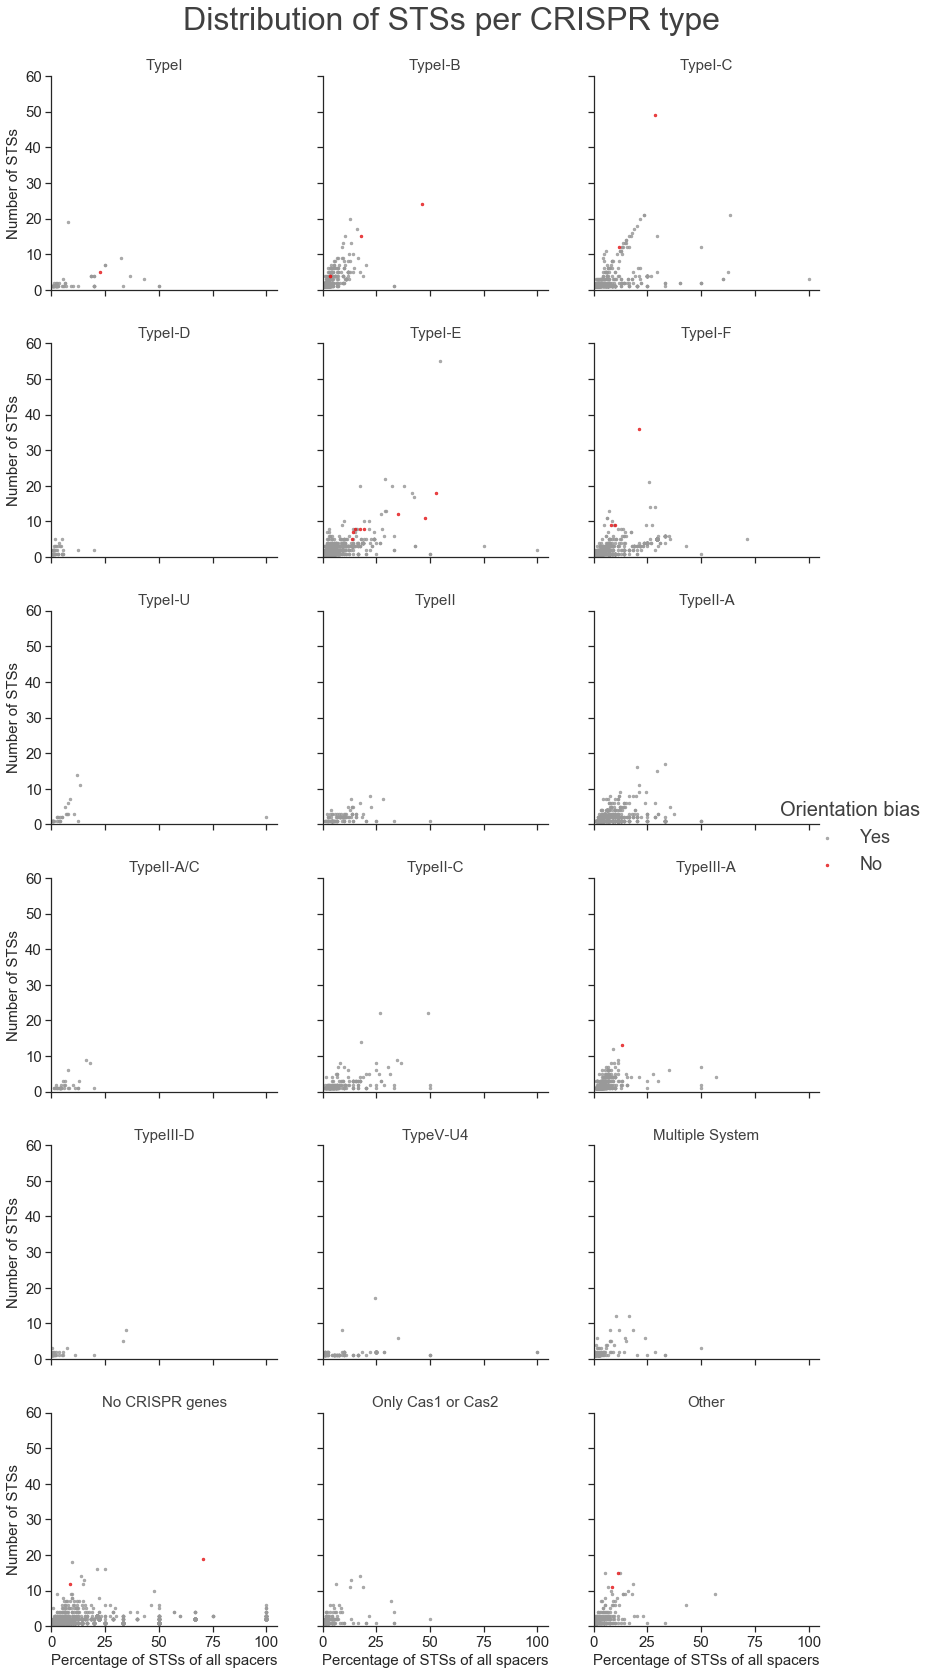

In [133]:
# color = 'royalblue'
sns.set_palette(cbf)
# plt.rc('legend',**{'title_fontsize':40})
g = sns.lmplot(data=single_df_limited, x="percentage_selfhits", y="selfhit_spacers", 
               col="typing", col_wrap=3, height=4, col_order=sorted(crisprlisted_limited, key=lambda x: "Z" + x if x[0] != "T" else x), 
               ci=None, fit_reg=False, robust=True, hue="orientation_bias", palette=cbf[6:],
               scatter_kws={'s': 6, }, line_kws={'linewidth': 1.3,},)
g.set(xlim=(0, 105))
g.set(ylim=(0, 60))
g.set_titles("{col_name}")
g.set_ylabels("Number of STSs")
g.set_xlabels("Percentage of STSs of all spacers")
plt.subplots_adjust(top=0.94)
g.fig.suptitle("Distribution of STSs per CRISPR type", fontsize=32)
plt.rcParams['legend.title_fontsize'] = 30
new_labels = ['Yes', 'No']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.setp(g._legend.get_title(), fontsize=20, text="Orientation bias")
plt.savefig("/home/hielke/bep/jups/bep_figs/Selfhit_spacers_in_types_dots.png", format='png', bbox_inches='tight')
# for ax in g.axes.flatten():
#     plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
#     plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title

In [45]:
sorted(crisprlisted_limited, key=lambda x: "Z" + x if x[0] != "T" else x)

['TypeI',
 'TypeI-B',
 'TypeI-C',
 'TypeI-D',
 'TypeI-E',
 'TypeI-E/F',
 'TypeI-F',
 'TypeI-U',
 'TypeII',
 'TypeII-A',
 'TypeII-A/C',
 'TypeII-B',
 'TypeII-C',
 'TypeIII-A',
 'TypeIII-B',
 'TypeIII-C',
 'TypeIII-D',
 'TypeV-A',
 'TypeV-B',
 'TypeV-U4',
 'TypeVI-B',
 'Multiple System',
 'No CRISPR genes',
 'Only Cas1 or Cas2',
 'Other']

In [41]:
single_df[(single_df.typing == "TypeIII-A") & (single_df['orientation_bias'] == True)].sort_values("selfhit_spacers")

,genome,Genes present,Number of CRISPRs,System type,Total Cas Prots,Total non V-U Prots,c_1,c_2,cas1 missing,contig_hit,genus,has_phages,missing RSAs,missing signature prot,multiple systems,prophage,species,system subtype,total_spacers,typing,more_inf,more_conf,orientation_bias,unknown_prophage,no_prophage,from_prophage,selfhit_count_sum,selfhit_count_mean,selfhit_count_median,selfhit_spacers,percentage_selfhits
genome,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1423543.3,1423543.3,DEDDh|DinG|c2c9|cas1|cas10|cas2|cas6|csm2|csm3...,1.0,TypeIII|TypeIV|TypeV-U,15.0,11.0,1174.0,1134.0,0,JKDE01000013,Mycobacterium,1.0,not all loci have repeats,0,3.0,0.0,Mycobacterium tuberculosis BTB11-210,TypeIII-A|TypeVU-4,100.0,TypeIII-A,"1,0,Complete",NaN,True,0.0,13.0,0.0,13,1.0,1.0,13,13.0


In [60]:
value_counts_all = genome_typing_complete.typing.value_counts()

In [75]:
make_sense_order = lambda x: "Z" + x if x[0] != "T" else x

In [79]:
# unbound
value_counts_single = single_df['typing'].value_counts()
value_counts_single_reordered = value_counts_single[
    sorted([g for g in value_counts_all.index if g in value_counts_single.index], 
           key=make_sense_order)] 
value_counts_all_filtered_reordered = value_counts_all[value_counts_single_reordered.index]
value_counts_all_filtered = value_counts_all[value_counts_single.index]
value_counts_perc = [(p / w * 100) for p, w in zip(value_counts_single_reordered, value_counts_all_filtered_reordered)]
value_counts_single_reordered

TypeI                  59
TypeI-A                 6
TypeI-A/B               1
TypeI-A/C               1
TypeI-B               828
TypeI-C               439
TypeI-C/E               6
TypeI-C/E/F             2
TypeI-C/F               9
TypeI-D                46
TypeI-E              1393
TypeI-E/F              24
TypeI-F              1095
TypeI-U                31
TypeII                125
TypeII-A              569
TypeII-A/C             34
TypeII-B               25
TypeII-C              198
TypeIII                 1
TypeIII-A            1278
TypeIII-A/D             3
TypeIII-B              26
TypeIII-B/C             1
TypeIII-C              26
TypeIII-D              33
TypeIV                  9
TypeV                   1
TypeV-A                22
TypeV-B                10
TypeV-C                 4
TypeV-D                 1
TypeV-E                 7
TypeV-U1                2
TypeV-U3                3
TypeV-U4              116
TypeV-U5                4
TypeVI-A                4
TypeVI-B    

In [92]:
# bound
value_counts_single = single_df_bounded['typing'].value_counts()
value_counts_single_reordered = value_counts_single[sorted(value_counts_all.index, 
                               key=make_sense_order)].dropna().astype('int64')
value_counts_single_reordered["Other"] = value_counts_single["Other"]
value_counts_single_reordered

def create_all_with_others(value_counts_single):
    others = value_counts_all.drop(value_counts_single.index, errors='ignore')
    res = value_counts_all[value_counts_single.index].dropna().astype('int64')
    res["Other"] = sum(others)
    return res
value_counts_all_filtered_reordered = create_all_with_others(value_counts_single_reordered)
value_counts_all_filtered = create_all_with_others(value_counts_single)
value_counts_perc = [(p / w * 100) for p, w in zip(value_counts_single_reordered, value_counts_all_filtered_reordered)]

/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [96]:
value_counts_single_reordered

TypeI                 19
TypeI-B              361
TypeI-C              204
TypeI-C/F              7
TypeI-D               21
TypeI-E              538
TypeI-E/F             18
TypeI-F              605
TypeI-U               16
TypeII                67
TypeII-A             237
TypeII-A/C            11
TypeII-B              13
TypeII-C              93
TypeIII-A            271
TypeIII-B             12
TypeIII-C             11
TypeIII-D             10
TypeV-A               12
TypeV-B                5
TypeV-E                6
TypeV-U4              56
TypeVI-B              12
Multiple System       43
No CRISPR genes      668
Only Cas1 or Cas2     61
Other                 22
Name: typing, dtype: int64

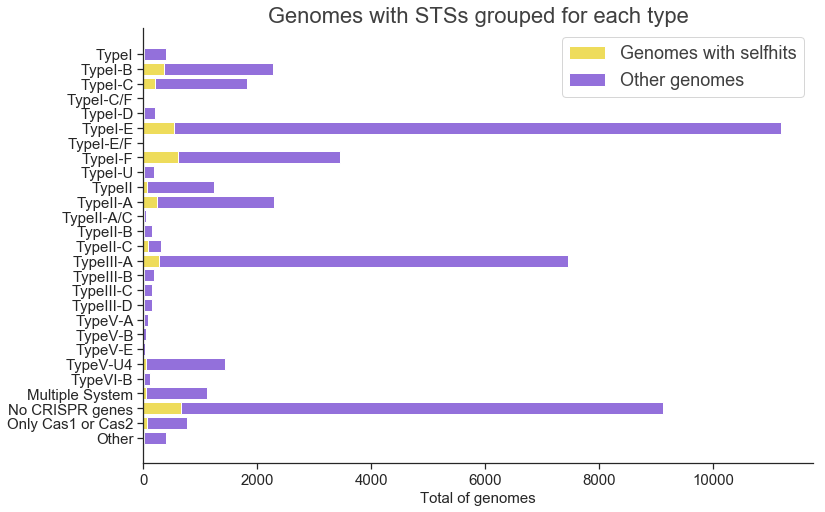

In [114]:
sns.set(rc=rc)
N = len(value_counts_single)

ind = list(range(N))[::-1]
ax = plt.barh(ind, value_counts_single_reordered, color=sns.xkcd_rgb["dull yellow"], )
plt.barh(ind, value_counts_all_filtered_reordered, left=value_counts_single_reordered, color='mediumpurple', )

plt.yticks(ind, value_counts_single_reordered.index)
plt.legend(['Genomes with selfhits', 'Other genomes'], loc='upper right')
plt.title("Genomes with STSs grouped for each type")
plt.xlabel("Total of genomes")
# plt.gca().set_xscale('log')
sns.despine()
increase_figsize(2, plt, )
plt.savefig("/home/hielke/bep/jups/bep_figs/Selfhit_genomes_vs_all.png", format='png', bbox_inches='tight')

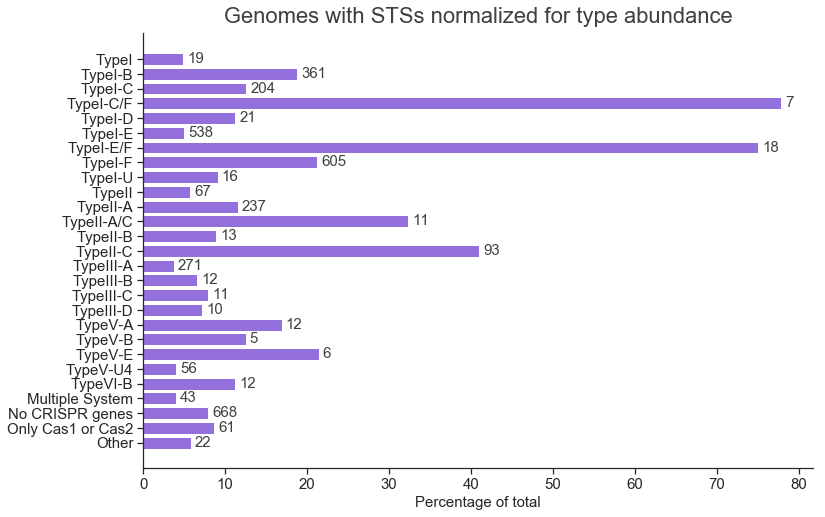

In [115]:
color="mediumpurple"
N = len(value_counts_single)
ind = list(range(N))[::-1]
fig, ax = plt.subplots()    
plt.barh(ind, value_counts_perc, color=color)
plt.yticks(ind, value_counts_single_reordered.index)
for i, v in enumerate(value_counts_single_reordered):
    ax.text(value_counts_perc[i]+0.5, ind[i]-0.25, str(v), color='0.25', fontsize=15)
plt.title("Genomes with STSs normalized for type abundance", y=1.01)
plt.xlabel("Percentage of total")
sns.despine()
increase_figsize(2, plt)
plt.savefig("/home/hielke/bep/jups/bep_figs/Selfhit_genomes_vs_all_perc.png", format='png', bbox_inches='tight')

In [110]:
interested = {"TypeI-C/F", "TypeI-E/F", "TypeI-A/C"}
print(len(single_df[single_df.typing.isin(interested)].index))
"|".join(single_df[single_df.typing.isin(interested)].index)

34


'1032488.3|1116030.3|1166016.3|1223567.3|1223572.3|1223573.3|1224148.3|1224150.8|1225785.3|1226343.9|1308956.3|1458466.5|208962.10|287.1182|287.1911|287.1914|287.2443|287.2977|287.4072|287.839|287.924|287.976|29447.10|29447.13|29447.18|29447.3|29447.7|350703.9|55208.11|55208.12|555.19|556.29|568766.3|579405.3'

/home/hielke/py/miniconda3/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


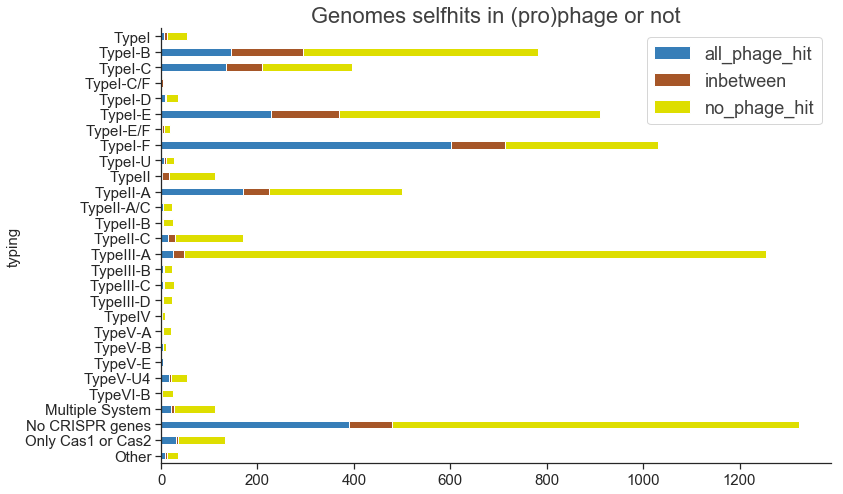

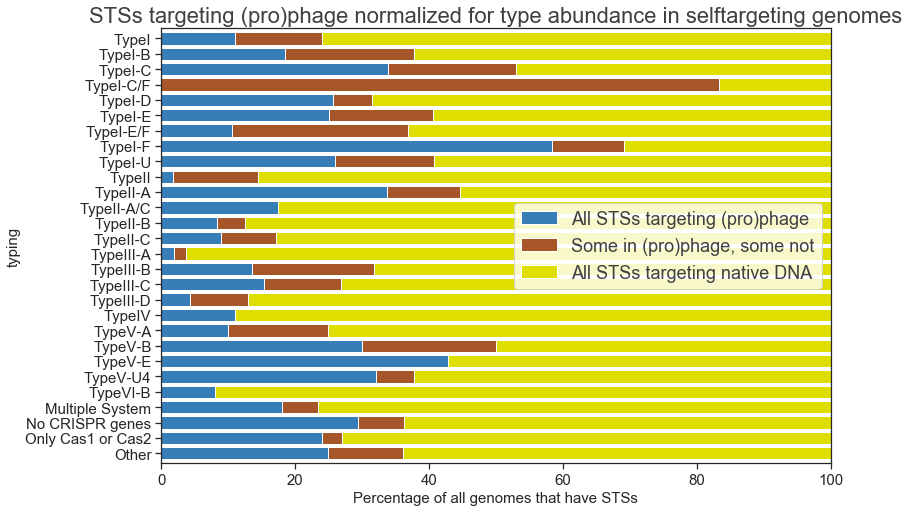

In [131]:
phage_hit_genome_level = single_df_phages.groupby("typing")['percentage_phagehit'].agg({"all_phage_hit": lambda x: sum(x==100.0), 
                                                                       "inbetween": 'count', 
                                                                       "no_phage_hit": lambda x: sum(x==0.0),
                                                                      })
phage_hit_genome_level['inbetween'] = phage_hit_genome_level['inbetween'] \
                                    - phage_hit_genome_level['all_phage_hit'] \
                                    - phage_hit_genome_level['no_phage_hit']
phage_hit_genome_level = phage_hit_genome_level.reindex(sorted(crisprlisted_phages, key=make_sense_order, reverse=True))
phage_hit_genome_level.plot.barh(stacked=True, cmap=cbf_map)
sns.despine()
plt.title("Genomes selfhits in (pro)phage or not")
increase_figsize(2, plt)
plt.savefig("/home/hielke/bep/jups/bep_figs/Selfhits_prophage_genomes.png", format='png', bbox_inches='tight')
phage_hit_genome_level_percentage = phage_hit_genome_level.div(phage_hit_genome_level.sum(axis=1), axis=0).mul(100)
phage_hit_genome_level_percentage.plot.barh(stacked=True, cmap=cbf_map, width=.8)
plt.gca().legend(loc='center right',  shadow=True)
plt.gca().set_xlim((0, 100))
plt.legend(['All STSs targeting (pro)phage', 'Some in (pro)phage, some not', 'All STSs targeting native DNA'], loc='center right')
plt.title("STSs targeting (pro)phage normalized for type abundance in selftargeting genomes")
plt.xlabel("Percentage of all genomes that have STSs")
increase_figsize(2, plt)
plt.savefig("/home/hielke/bep/jups/bep_figs/Selfhits_prophage_genomes_perc.png", format='png', bbox_inches='tight')